
‘BREADBASKET BAKERY SALES PREDICTION’**

For this open ended task, we will examine the **Bread Basket Dataset**, which contains all transactions from an Edinburgh bakery between 30th October 2016 and 9th April 2017. We we will also use the a weather dataset for the same period to gain more insights.

In the following notebook I've outlined my thought porcess (and mistakes) and performed two main tasks:

1.   I have built a classifier that predicts whether a hot beverage will be sold given the time and weather conditions of a sale (More of a proof of concept). Disclaimer: From the first stage of building the classifier I was aware that the task is too optimistic as the data is very granular. However, I still outline wy methodology and main steps.

2.  I have built a regression model that predicts the number of sales for a given hour of day and some whether conditions at that hour. 

For both cases, a corresponding neural network was trained and compared to a more simple algorithm.




Before staring the analysis, we first import the required libraries and packages:

In [ ]:
#Import libraries
import numpy as np
import pandas as pd
from datetime import datetime
import math
from collections import Counter

#For plotting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.graph_objects as go
import seaborn as sns
from tqdm.notebook import tqdm

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import f1_score
from xgboost import XGBRegressor

In [ ]:
#Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.autograd import Variable



Next, we mount the Colab notebook to the relevant Google Drive folder in order to load the two datasets as Pandas dataframe. This format will be used for all dataset throughout the notebook:

In [ ]:
#Mount drivw

from google.colab import drive
drive.mount('/content/gdrive')

#Define file paths
file_path = 'gdrive/My Drive/####
bb_path = 'gdrive/My Drive/####/
weather_path = 'gdrive/My Drive/####

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Define datasets
df_sales = pd.read_csv(bb_path)
df_weather = pd.read_csv(weather_path)

Both the sales and weather datasets for the same period follow below:

In [ ]:
df_sales

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam
...,...,...,...,...
21288,2017-04-09,14:32:58,9682,Coffee
21289,2017-04-09,14:32:58,9682,Tea
21290,2017-04-09,14:57:06,9683,Coffee
21291,2017-04-09,14:57:06,9683,Pastry


In [ ]:
df_weather

,Date,Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Precip Accum,Condition
0,2016-10-30,00:20,52,48,88,SW,7,0,30.3,0.0,0.0,Cloudy
1,2016-10-30,00:50,52,48,88,WSW,6,0,30.3,0.0,0.0,Cloudy
2,2016-10-30,01:20,52,48,88,W,7,0,30.2,0.0,0.0,Cloudy
3,2016-10-30,01:50,52,48,88,W,6,0,30.2,0.0,0.0,Cloudy
4,2016-10-30,01:20,50,48,94,WSW,5,0,30.2,0.0,0.0,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...
7759,2017-04-09,21:50,43,37,81,WSW,12,0,29.9,0.0,0.0,Fair
7760,2017-04-09,22:20,43,37,81,WSW,12,0,29.9,0.0,0.0,Fair
7761,2017-04-09,22:50,43,37,81,WSW,13,0,29.9,0.0,0.0,Fair
7762,2017-04-09,23:20,41,37,87,WSW,10,0,29.9,0.0,0.0,Fair


Here, we create an additional dataframe which shows the total sales, most common item sold and most common weather condition for each day. At this point, this is part of brainstorming ideas to gain a better understanding of the data

In [ ]:
#Find uniques shop items:
unique_shop_items = df_sales['Item'].unique().tolist()

In [ ]:
#Group Items sold by date
df_sales_num = df_sales.groupby('Date').size().reset_index(
    name ='Total Items Sold')
df_sales_num

,Date,Total Items Sold
0,2016-10-30,180
1,2016-10-31,205
2,2016-11-01,154
3,2016-11-02,169
4,2016-11-03,195
...,...,...
154,2017-04-05,145
155,2017-04-06,119
156,2017-04-07,103
157,2017-04-08,209


In [ ]:
#Most common item and weather per date
df_item_max=df_sales.groupby('Date')['Item'].apply(
    lambda x: x.value_counts().index[0]).reset_index()
df_weather_max=df_weather.groupby('Date')['Condition'].apply(
    lambda x: x.value_counts().index[0]).reset_index()

In [ ]:
#Merge on date
df_merged_1 = pd.merge(df_sales_num, df_item_max, on='Date')
df_merged_2 = pd.merge(df_merged_1, df_weather_max, on='Date')

In [ ]:
df_merged_2['Date']= pd.to_datetime(df_merged_2['Date'])

The aforementioned dataset with the sales, most common item and most common condition is shown below:

In [ ]:
df_merged_2

,Date,Total Items Sold,Item,Condition
0,2016-10-30,180,Coffee,Fair
1,2016-10-31,205,Coffee,Fair
2,2016-11-01,154,Coffee,Fair
3,2016-11-02,169,Coffee,Fair
4,2016-11-03,195,Coffee,Fair
...,...,...,...,...
154,2017-04-05,145,Coffee,Partly Cloudy
155,2017-04-06,119,Coffee,Mostly Cloudy
156,2017-04-07,103,Coffee,Mostly Cloudy
157,2017-04-08,209,Coffee,Fair


Before moving on to specifics, we also plot the total sales by day for the entire period. This might give us a better understanding of underlying trends.

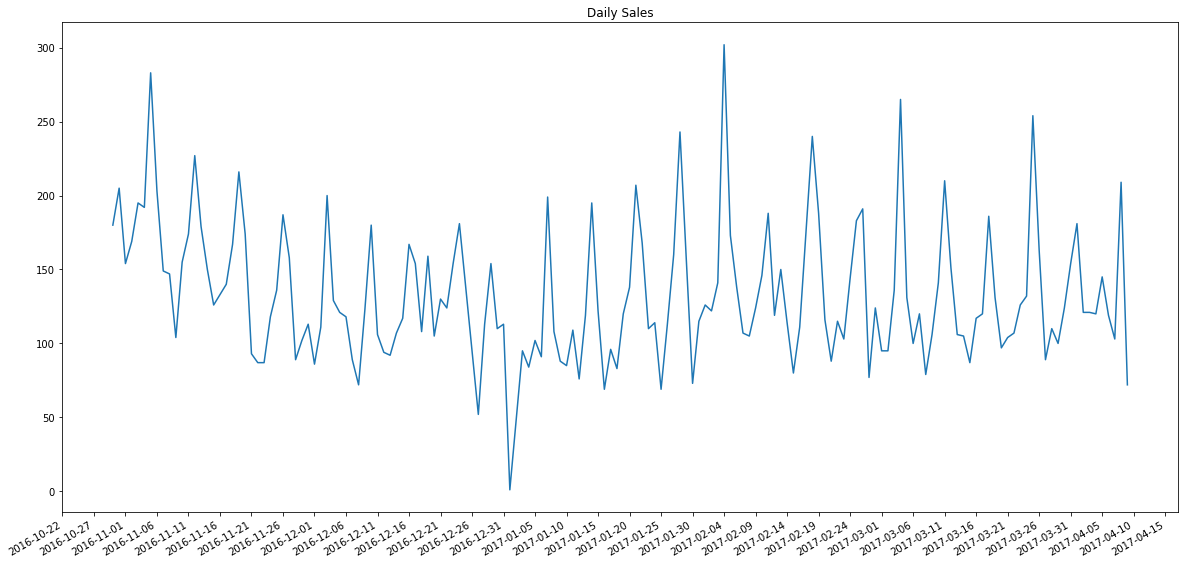

In [ ]:
#Plot Total Sale by date

plt.figure(figsize=(20,10))
plt.title('Daily Sales')
axis1 = plt.gca()
axis1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axis1.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.plot(df_merged_2['Date'], df_merged_2['Total Items Sold'])
plt.gcf().autofmt_xdate()
plt.show()

The above plot shows a fluctuating trend between sales per day, which might suggest that weather conditions play affect the number of sales. At this point, the two tables are still separate. Ideally, we would like to join the two in order to have weathe conditions and sales side-by-side. However a small problem arises here: The weather data contains two data points per hour with one at twenty past and another at fifty past the hour, while the sales data is very granular. 

As we want to have as many data points as possible, we want to keep the size of the sales dataset which is larger. In order to do this we will assume that the weather that corresponds to each sale is that of the last reading. For example, if a sale is at 11:45 am we will take the weather reading for 11:20am. Based on this assumption, we merge the two tables:



In [ ]:
#Concatenate date & time strings
df_sales['Datetime']=pd.to_datetime(
    df_sales['Date'] + ' ' + df_sales['Time'])
df_weather['Datetime']=pd.to_datetime(
    df_weather['Date'] + ' ' + df_weather['Time'])

In [ ]:
#Get unique winds and conditions for weather data
unique_winds = df_weather['Wind'].unique().tolist()
unique_conditions = df_weather['Condition'].unique().tolist()

In [ ]:
#Group weather data by dates
weather_avg = df_weather.groupby('Date').mean()

In [ ]:
df_weather.sort_values("Datetime", inplace=True)

In [ ]:
#Merge weather dataset on sales dataset based on time intervals
df = pd.merge_asof(df_sales, df_weather,   on = 'Datetime', by='Date')

The merged table follows below:

In [ ]:
df.head(10)

,Date,Time_x,Transaction,Item,Datetime,Time_y,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Precip Accum,Condition
0,2016-10-30,09:58:11,1,Bread,2016-10-30 09:58:11,09:50,54,50,88,VAR,3,0,30.2,0.0,0.0,Fair
1,2016-10-30,10:05:34,2,Scandinavian,2016-10-30 10:05:34,09:50,54,50,88,VAR,3,0,30.2,0.0,0.0,Fair
2,2016-10-30,10:05:34,2,Scandinavian,2016-10-30 10:05:34,09:50,54,50,88,VAR,3,0,30.2,0.0,0.0,Fair
3,2016-10-30,10:07:57,3,Hot chocolate,2016-10-30 10:07:57,09:50,54,50,88,VAR,3,0,30.2,0.0,0.0,Fair
4,2016-10-30,10:07:57,3,Jam,2016-10-30 10:07:57,09:50,54,50,88,VAR,3,0,30.2,0.0,0.0,Fair
5,2016-10-30,10:07:57,3,Cookies,2016-10-30 10:07:57,09:50,54,50,88,VAR,3,0,30.2,0.0,0.0,Fair
6,2016-10-30,10:08:41,4,Muffin,2016-10-30 10:08:41,09:50,54,50,88,VAR,3,0,30.2,0.0,0.0,Fair
7,2016-10-30,10:13:03,5,Coffee,2016-10-30 10:13:03,09:50,54,50,88,VAR,3,0,30.2,0.0,0.0,Fair
8,2016-10-30,10:13:03,5,Pastry,2016-10-30 10:13:03,09:50,54,50,88,VAR,3,0,30.2,0.0,0.0,Fair
9,2016-10-30,10:13:03,5,Bread,2016-10-30 10:13:03,09:50,54,50,88,VAR,3,0,30.2,0.0,0.0,Fair


From the table we can also model the relationship between weather and sales and we can also show the most commonly sold items. Both of these relationships are shown in the two following plots:

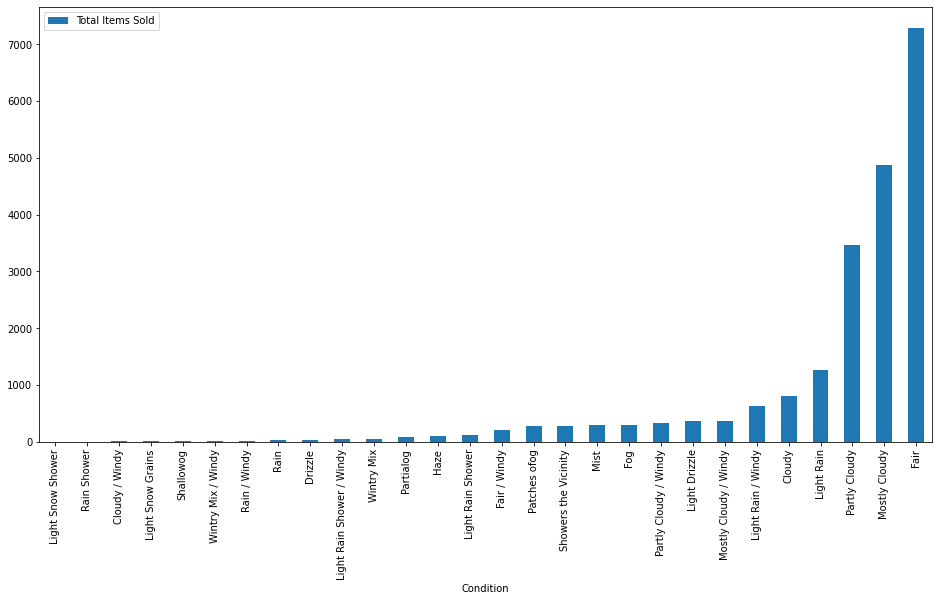

In [ ]:
df_items_by_condition=df.groupby('Condition').size().reset_index(
    name ='Total Items Sold')
df_items_by_condition.sort_values(['Total Items Sold']).plot.bar(
    figsize=(16,8),x='Condition',y='Total Items Sold',stacked=True)

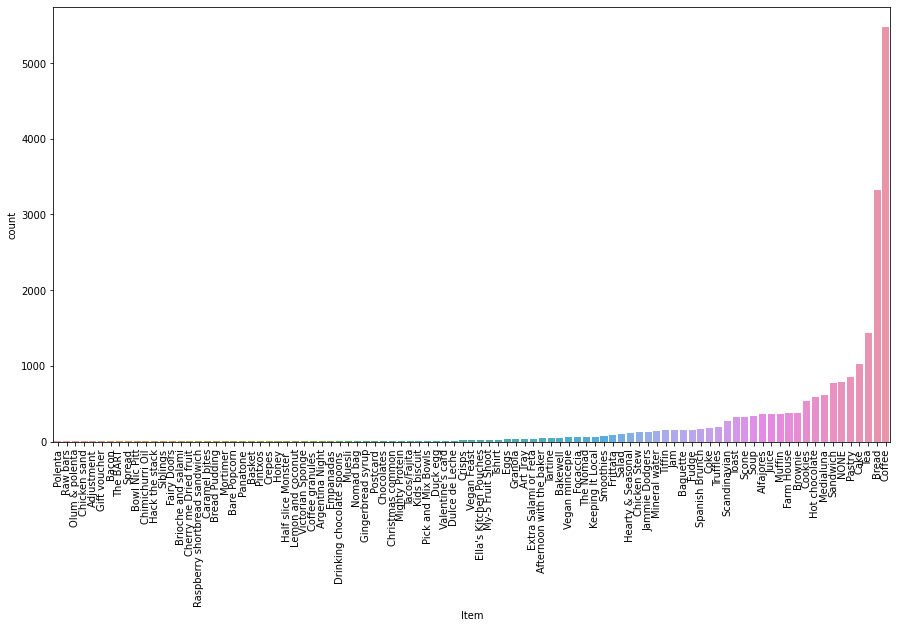

In [ ]:
#Plot counts of items sold
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
ax = sns.countplot(x = 'Item', data=df, order=df['Item'].value_counts().sort_values().index)

**My first attempt-Classification:**

Having joined the tables, and having data relaated to each sale, my initial thought is to try and predict the item (class) sold given the time and weather related data. Of course, I'd be very optimistic to think that I can easily get good results, as there is a great variation between items sold. Let's see..

First of all, we remove the items with less than 100 sales as these are not very relevant for the classiciation task. We also plot the remaining item counts:

In [ ]:
#Clean up items as some appear only a few times
item_count = dict(df['Item'].value_counts())
reduced_items= [key for key, val in item_count.items() if (val >= 100 )]#and val<=2000)]
df = df.loc[df['Item'].isin(reduced_items)]

In [ ]:
#remove empty items
df = df[df.Item != 'NONE']

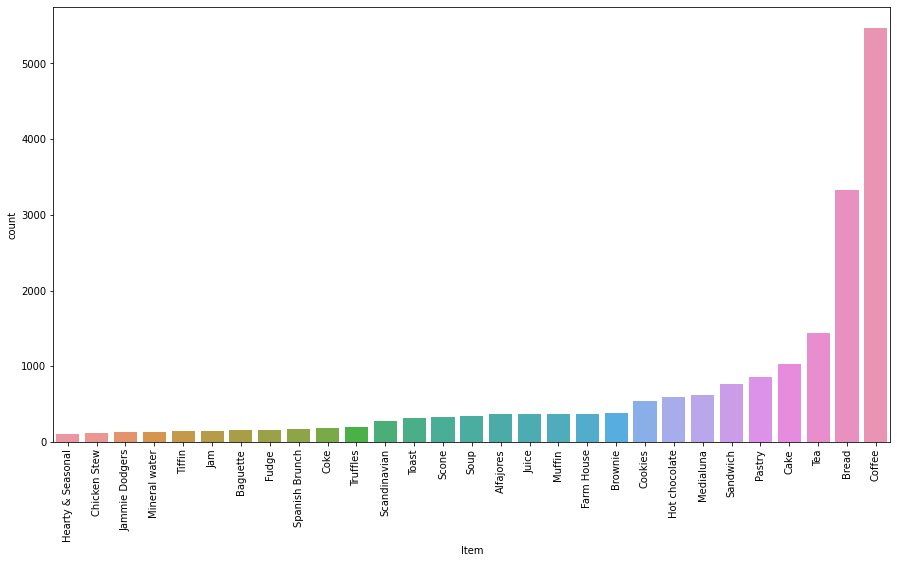

In [ ]:
#Plot cleaned up items
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
ax = sns.countplot(x = 'Item', data=df, order=df['Item'].value_counts().sort_values().index)

As there are still many different items (30 to be exact) I will group them in larger classes, such as those see in the get_type function below:

In [ ]:
item_list = df.Item.unique().tolist()

In [ ]:
def get_type(item):
  '''
  returns type of the item
  '''

  type_dict = {'sweets':['Fudge', 'Cake',  'Brownie','Truffles', 'Cookies','Muffin',  'Tiffin',  'Alfajores',  'Jammie Dodgers',  'Jam'],
'hot_beverages':['Coffee', 'Tea',  'Hot chocolate'],
'cold_beverages':['Juice',  'Coke',  'Mineral water',],
'bread':['Bread','Baguette'],
'pastry':[ 'Pastry','Medialuna', 'Scandinavian', 'Scone'],
'brunch':['Spanish Brunch'],
'hot_plates':['Chicken Stew', 'Soup', 'Hearty & Seasonal'],
'snacks':['Sandwich','Toast', 'Farm House']}

  for key in type_dict.keys():
    if item in type_dict[key]:
      return key


As I also want to use the time of sale as a feature, I wanted to think of a nice way to encode time. First, I will create a separate column that will show the exact minute of the day as an integer (i.e. 11:59pm = 1439)

In [ ]:
def time_to_integer(time_str):
  '''
  function that takes in time as string and returns integer minutes
  from 0 to 1439)
  '''
  time_object = datetime.strptime(time_str, '%H:%M:%S').time()
  hour = time_object.hour*60
  minute = time_object.minute
  int = hour + minute

  return int

I also create a separate column where have an indication on whether its morning or afternoon

In [ ]:
def morning_or_afternoon(x):
  
  if x <= 12:
    return 'Morning'
  else:
    return 'Afternoon'

In [ ]:
def hot_or_other(x):
  
  if x == 'hot_beverages':
    return 0
  else:
    return 1

Below, I create the additional feature. The **Hot beverage ** column will be of binary type where we will have a 0 if the item sold is a hot beverage and a 1 if not. (At this point I've decided to treat the problem as a binary classification task where given the time and conditions I will predict wheteher or not we will sell a hot drink)

In [ ]:
#Transform times to integer minutes
df['Integer_time'] = df['Time_x'].apply(lambda x: time_to_integer(x))
df['Hour_of_day'] = df['Time_x'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time().hour)
df['Item_type'] = df['Item'].apply(lambda x: get_type(x))
df['AM/PM'] = df['Hour_of_day'].apply(lambda x: morning_or_afternoon(x))
df['Hot_Drink'] = df['Item_type'].apply(lambda x: hot_or_other(x))

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Day_of_week'] = df['Date'].dt.dayofweek

In [ ]:
max_int_time = df['Integer_time'].max()

Adding some cyclical features for the time (cos_time and sin_time) in order to preserve cyclical significance. I also visualise the new coordinate system for these features

In [ ]:
#Get cyclcic times (normalize and get sin, cos)
df["x_norm"] = 2 * math.pi * df['Integer_time'] /1439
df["cos_x"] = np.cos(df["x_norm"])
df["sin_x"] = np.sin(df["x_norm"])

In [ ]:
df_2 = df

In [ ]:

df.to_csv('data.csv')
!cp data.csv "gdrive/My Drive/xerini/"

Below I plot the new coordinate system for the time features:

In [ ]:
#Plot the times on the new coordinate system:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.cos_x, y=df.sin_x, mode="markers"))
fig.update_layout(xaxis = dict(title="cos_x"),
                  yaxis = dict(title="sin_x", scaleanchor = "x", scaleratio = 1))
fig.show()

As the data in the table will be used as input to a neural net, it needs to be encoded numerically:

In [ ]:
#Encode categorical labels in both datasets

df.Wind = df.Wind.astype('category').cat.codes
df.Condition = df.Condition.astype('category').cat.codes
df.Item_type = df.Item_type.astype('category').cat.codes
df.Item = df.Item.astype('category').cat.codes
df['AM/PM'] = df['AM/PM'].astype('category').cat.codes

In [ ]:
df

,Date,Time_x,Transaction,Item,Datetime,Time_y,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Precip Accum,Condition,Integer_time,Hour_of_day,Item_type,AM/PM,Hot_Drink,Day_of_week,x_norm,cos_x,sin_x
0,2016-10-30,09:58:11,1,2,2016-10-30 09:58:11,09:50,54,50,88,14,3,0,30.2,0.0,0.0,3,598,9,0,1,1,6,2.611080,-0.862548,0.505975
1,2016-10-30,10:05:34,2,21,2016-10-30 10:05:34,09:50,54,50,88,14,3,0,30.2,0.0,0.0,3,605,10,5,1,1,6,2.641645,-0.877608,0.479380
2,2016-10-30,10:05:34,2,21,2016-10-30 10:05:34,09:50,54,50,88,14,3,0,30.2,0.0,0.0,3,605,10,5,1,1,6,2.641645,-0.877608,0.479380
3,2016-10-30,10:07:57,3,12,2016-10-30 10:07:57,09:50,54,50,88,14,3,0,30.2,0.0,0.0,3,607,10,3,1,0,6,2.650378,-0.881760,0.471698
4,2016-10-30,10:07:57,3,13,2016-10-30 10:07:57,09:50,54,50,88,14,3,0,30.2,0.0,0.0,3,607,10,7,1,1,6,2.650378,-0.881760,0.471698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21286,2017-04-09,14:32:58,9682,18,2017-04-09 14:32:58,14:20,59,46,63,15,16,0,29.8,0.0,0.0,15,872,14,7,0,1,6,3.807462,-0.786380,-0.617743
21288,2017-04-09,14:32:58,9682,6,2017-04-09 14:32:58,14:20,59,46,63,15,16,0,29.8,0.0,0.0,15,872,14,3,0,0,6,3.807462,-0.786380,-0.617743
21289,2017-04-09,14:32:58,9682,25,2017-04-09 14:32:58,14:20,59,46,63,15,16,0,29.8,0.0,0.0,15,872,14,3,0,0,6,3.807462,-0.786380,-0.617743
21290,2017-04-09,14:57:06,9683,6,2017-04-09 14:57:06,14:50,57,45,63,17,16,0,29.8,0.0,0.0,15,897,14,3,0,0,6,3.916621,-0.714401,-0.699736


Below I define the label I'm trying to predict, as well as the feature columns. I've tried several different combinations, and the classifier is built in a way that can perofrm both binary-in this case, and multiclass classification (softmax output).

In [ ]:
#Define list of features
d_variable = 'Hot_Drink'
features = ['Day_of_week','AM/PM','Temperature','Condition']

In [ ]:
# #Clean up items as some appear only a few times
# item_count_2 = dict(df['Item_type'].value_counts())
# reduced_items_2= [key for key, val in item_count_2.items() if (val >= 100 )]#and val<=2000)]
# df = df.loc[df['Item_type'].isin(reduced_items_2)]

In [ ]:
#Define inpute and outputs
X = df[features]
y = df[[d_variable]]

The data is split to train-val-test (9-1-1). As the dataset is imbalanced, stratification is used to ensure equal distribution within the three sets

In [ ]:

X_both, X_test, y_both, y_test = train_test_split(X, y, test_size=0.2,
                                                          stratify=y,
                                                          random_state=69)
X_train, X_val, y_train, y_val = train_test_split(X_both, y_both,
                                                  test_size=0.1,
                                                  stratify=y_trainval,
                                                  random_state=21)

Having split the dataset, the features are transformed by scaling them to a range between (0,1). This will ensure that they are compatible to the NN input format.

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val, X_test= scaler.transform(X_val), scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
train_counts = Counter(y_train.flatten().tolist())
val_counts = Counter(y_val.flatten().tolist())
test_counts = Counter(y_test.flatten().tolist())

Below, we get the data to tensor form in order to feed it to the NN

In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
        
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

As the dataset is imbalanced, we create a value count of our samples, in order to build a weighted dampler (according to the occurance of each class). This will ensure that the batches fed to the network have similar distribution

In [ ]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [ ]:
class_count = [i for i in Counter(y_train.flatten().tolist()).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights_total = class_weights[target_list]


In [ ]:
weighted = WeightedRandomSampler(
    weights=class_weights_total,
    num_samples=len(class_weights_total),
    replacement=True
)

Below we define the hyperparameters of the neural net and we also call the dataloaders

In [ ]:
num_epochs = 50
batch_size= 16
learning_rate = 0.0008
n_features = len(X.columns)
n_classes = len(y[d_variable].unique())

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          sampler=weighted
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Finally we build the classifier. The network will take inputs equal to the number of features and will output a number of logits equal to the classes (2 in this case). 5 linear layers are used, each followed by a batchnorm layer to stbilize training and a relu activation function. Dropout layers are also used to prevent overfitting. This network can perform both ninary and multi-class classification, depending on the relevant hyper-parameters

In [ ]:
class Classifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Classifier, self).__init__()
        
        self.fc_1 = nn.Linear(num_features, 1024)
        self.fc_2 = nn.Linear(1024, 512)
        self.fc_3 = nn.Linear(512, 256)
        self.fc_4 = nn.Linear(256,128)
        self.fc_5 = nn.Linear(128,64)
        self.fc_out = nn.Linear(64, num_classes) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.bn_1 = nn.BatchNorm1d(1024)
        self.bn_2 = nn.BatchNorm1d(512)
        self.bn_3 = nn.BatchNorm1d(256)
        self.bn_4 = nn.BatchNorm1d(128)
        self.bn_5 = nn.BatchNorm1d(64)
        
    def forward(self, x):

        x = self.fc_1(x)
        x = self.bn_1(x)
        x = self.relu(x)
        
        x = self.fc_2(x)
        x = self.bn_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_3(x)
        x = self.bn_3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_4(x)
        x = self.bn_4(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_5(x)
        x = self.bn_5(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        return(self.fc_out(x))
        


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
classification_model = Classifier(num_features = n_features, num_classes=n_classes)
classification_model.to(device)
print(classification_model)


Classifier(
  (fc_1): Linear(in_features=4, out_features=1024, bias=True)
  (fc_2): Linear(in_features=1024, out_features=512, bias=True)
  (fc_3): Linear(in_features=512, out_features=256, bias=True)
  (fc_4): Linear(in_features=256, out_features=128, bias=True)
  (fc_5): Linear(in_features=128, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (bn_1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


For the criterion, we use CrossEntropy Loss (with logits). That is, the traditional crossentropy function will also apply softmax on the logits (and hence the latter is ommited from the network)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(classification_model.parameters(), lr=learning_rate)


In [ ]:
def get_acc(y_pred, y_test):
  '''
  Takes predictions and target labels and predictis accuracy
  '''
  softmax_out = torch.log_softmax(y_pred, dim = 1)
  lgts, lbl_pred = torch.max(softmax_out, dim = 1)    
  sum_correct = (lbl_pred == y_test.flatten()).float()
  acc = sum_correct.sum() / len(sum_correct)

  return(torch.round(acc * 100))

Below, we train the network recording both per epoch loss and accuracy:

In [ ]:
acc_dict = {'training': list(),"validation": list()}
loss_dict = {'training': list(),"validation": list()}

for epoch in tqdm(range(1, num_epochs+1)):
    
  train_epoch_loss = 0
  train_epoch_acc = 0
  classification_model.train()

  for train_item, train_labels in train_loader:

    train_item,train_labels = train_item.to(device), train_labels.to(device)
    optimizer.zero_grad()
    
    lbl_pred= classification_model(train_item)
    
    train_loss = criterion(lbl_pred, train_labels.flatten())
    train_acc = get_acc(lbl_pred, train_labels.flatten())
    train_loss.backward()
    optimizer.step()
    
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()
      
        

  with torch.no_grad():
        
    val_epoch_loss = 0
    val_epoch_acc = 0
        
    classification_model.eval()

    for val_item, val_labels in val_loader:
      val_item, val_labels = val_item.to(device), val_labels.to(device)
      
      lbl_pred = classification_model(val_item)
            
      val_loss = criterion(lbl_pred, val_labels.flatten())
      val_acc = get_acc(lbl_pred, val_labels.flatten())
      
      val_epoch_loss += val_loss.item()
      val_epoch_acc += val_acc.item()

  train_loss_avg = train_epoch_loss/len(train_loader)
  val_loss_avg = val_epoch_loss/len(val_loader)
  train_acc_avg = train_epoch_acc/len(train_loader)
  val_acc_avg = val_epoch_acc/len(val_loader)

  loss_dict['training'].append(train_loss_avg)
  loss_dict['validation'].append(val_epoch_loss/len(val_loader))
  acc_dict['training'].append(train_epoch_acc/len(train_loader))
  acc_dict['validation'].append(val_epoch_acc/len(val_loader))
                              
          
  print(f'==>Epoch {epoch+0:03}: || Training Loss: {train_loss_avg:.5f} | Validation Loss: {val_loss_avg:.5f} | Training Accuracy: {train_acc_avg:.3f}| Validation Acc: {val_acc_avg :.3f}')



  0%|          | 0/50 [00:00<?, ?it/s]

==>Epoch 001: || Training Loss: 0.70583 | Validation Loss: 0.69732 | Training Accuracy: 51.538| Validation Acc: 48.629
==>Epoch 002: || Training Loss: 0.69659 | Validation Loss: 0.69282 | Training Accuracy: 51.320| Validation Acc: 50.948
==>Epoch 003: || Training Loss: 0.69523 | Validation Loss: 0.69325 | Training Accuracy: 52.521| Validation Acc: 52.093
==>Epoch 004: || Training Loss: 0.69403 | Validation Loss: 0.69415 | Training Accuracy: 53.338| Validation Acc: 57.577
==>Epoch 005: || Training Loss: 0.69418 | Validation Loss: 0.69240 | Training Accuracy: 52.701| Validation Acc: 57.351
==>Epoch 006: || Training Loss: 0.69407 | Validation Loss: 0.69512 | Training Accuracy: 51.189| Validation Acc: 40.113
==>Epoch 007: || Training Loss: 0.69264 | Validation Loss: 0.69434 | Training Accuracy: 54.704| Validation Acc: 46.722
==>Epoch 008: || Training Loss: 0.69385 | Validation Loss: 0.69387 | Training Accuracy: 51.977| Validation Acc: 46.289
==>Epoch 009: || Training Loss: 0.69407 | Valida

We plot the both loss and accuracy per epoch below:

Text(0.5, 1.0, 'Loss per Epoch')

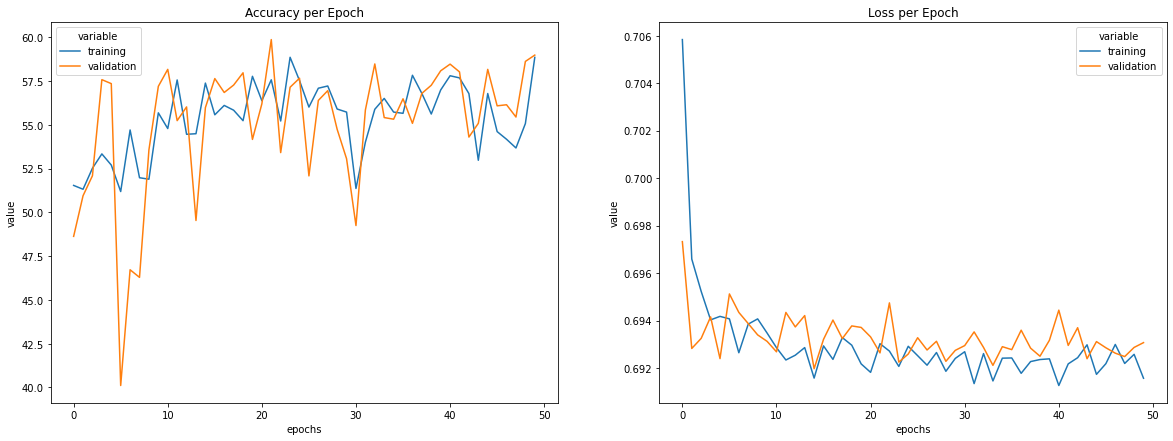

In [ ]:

df_acc_class = pd.DataFrame.from_dict(acc_dict).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
df_loss_class = pd.DataFrame.from_dict(loss_dict).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=df_acc_class, x = "epochs", 
             y="value", hue="variable",
             ax=axes[0]).set_title('Accuracy per Epoch')
sns.lineplot(data=df_loss_class,
             x = "epochs", 
             y="value", 
             hue="variable", 
             ax=axes[1]).set_title('Loss per Epoch')

As we can see, although the network learns, it is not very steady, while validation accuracy and validation loss stagnate at 60% and 0.692% respectively. This was somewhat expected, as it is difficult to outline a relationship between the exact time and conditions and the item sold under that time and those conditions.

In [ ]:
test_predictions = list()
with torch.no_grad():
    classification_model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = classification_model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        test_predictions.append(y_pred_tags.cpu().numpy())
test_predictions = [pred.squeeze().tolist() for pred in test_predictions]

In [ ]:
print('NN accuracy score: {0:0.4f}'. format(accuracy_score(y_test, test_predictions)))

NN accuracy score: 0.6037


For the sake of comparison, we also fit an SVM to the training data, only to record the same performance on unseen instances 

In [ ]:
svc=SVC() 
svc.fit(X_train,y_train.ravel())
y_pred_svm=svc.predict(X_test)

In [ ]:
print('SVM accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_svm)))

SVM accuracy score: 0.6135


As we can see, the accuracy scores for both models are similar and relatively low.

**Regression**

As the use of very granular data points did not prove to be very useful, I decided to try something different. Specifically, I decided to group the sales by hour of day (9, 10.... 23) for each date and try to predict the number of sales given **each hour** and the average or most common conditions **for that hour**. 

Namely, as seen below, the total sales are counted for each hour, whereas we take the most common weather condition, and the averages of temperature, wind, and rain. We also record the day of the week and whether it's morning or afternoon. All of the aforementioned features can be used to predict the number of sales on a given hour of the day

In [ ]:
#Create groups for regression dataset
df3 = df_2.groupby(['Date','Hour_of_day']).agg(cond_mod  = ('Condition', \
                                        lambda x: x.value_counts().index[0]),
                                         avg_temp = ('Temperature', 'mean'),
                                          day = ('Day_of_week', 'mean'),
                                        sales_per_hour = ('Hour_of_day', 'size'),
                                         avg_rain =  ('Precip.', 'mean'),
                                          am_pm =  ('AM/PM', 'mean'),
                                           avg_wind =  ('Wind', 'mean'))

The dataset is shown below:

In [ ]:
df3

cond_mod   avg_temp  day  ...  avg_rain  am_pm   avg_wind
Date       Hour_of_day                            ...                            
2016-10-30 9                   3  54.000000    6  ...       0.0      1  14.000000
           10                  3  54.109091    6  ...       0.0      1  15.909091
           11                  3  55.923077    6  ...       0.0      1  15.923077
           12                  3  55.000000    6  ...       0.0      1  15.000000
           13                  3  56.538462    6  ...       0.0      0  15.000000
...                          ...        ...  ...  ...       ...    ...        ...
2017-04-09 10                  3  55.555556    6  ...       0.0      1  14.888889
           11                  3  59.375000    6  ...       0.0      1  16.250000
           12                  3  61.000000    6  ...       0.0      1  17.000000
           13                 18  59.800000    6  ...       0.0      0  15.000000
           14                 15  58.272727    6  ...       0.0      0  15.363636

[1487 rows x 7 columns]

In [ ]:
#save to drive
df3.to_csv('data2.csv')
!cp data2.csv "gdrive/My Drive/xerini/"

In [ ]:
#load again just to make sure
df4 = pd.read_csv("gdrive/My Drive/xerini/data2.csv")

In [ ]:
#Check features
df4.columns

Index(['Date', 'Hour_of_day', 'cond_mod', 'avg_temp', 'day', 'sales_per_hour',
       'avg_rain', 'am_pm', 'avg_wind'],
      dtype='object')

The below steps are very similar to the classification steps (define features,  split data, create loaders etc). The only difference here is that we don't care about imbalances as we are no longer dealing with a classification problem

In [ ]:
#Features and target
features = ['Hour_of_day', 'cond_mod', 'avg_temp', 'day','am_pm']
d_variable = 'sales_per_hour'

In [ ]:
X = df4[features]
y = df4[[d_variable]]

In [ ]:
#Split dataset
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_1, y_1, test_size=0.1, random_state=43)

In [ ]:
#Transform 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val, X_test = scaler.transform(X_val), scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
class RegressorDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = RegressorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [ ]:
num_epochs = 1000
batch_size = 64
learning_rate = 0.0007
num_features = len(X.columns)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size= batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Below, we define the regression model. This will take the features as inputs and consist of 6 linaear layers followed by Relu activations. As we are performing regression, we don't want an activation at the output layer, and we output a single value

In [ ]:
class Regression(nn.Module):

  def __init__(self, num_features):
    super(Regression, self).__init__()
    
    self.fc_1 = nn.Linear(num_features, 16)
    self.fc_2 = nn.Linear(16, 32)
    self.fc_3 = nn.Linear(32, 64)
    self.fc_4 = nn.Linear(64, 32)
    self.fc_5 = nn.Linear(32, 16)
    self.fc_6 = nn.Linear(16, 4)
    self.fc_out = nn.Linear(4, 1)
    
    self.relu = nn.ReLU()
    
  def forward(self, x_in):
    x = self.relu(self.fc_1(x_in))
    x = self.relu(self.fc_2(x))
    x = self.relu(self.fc_3(x))
    x = self.relu(self.fc_4(x))
    x = self.relu(self.fc_5(x))
    x = self.relu(self.fc_6(x))
    
    return(self.fc_out(x))



In [ ]:
model_regression = Regression(num_features)
model_regression.to(device)
print(model_regression)


Regression(
  (fc_1): Linear(in_features=5, out_features=16, bias=True)
  (fc_2): Linear(in_features=16, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=64, bias=True)
  (fc_4): Linear(in_features=64, out_features=32, bias=True)
  (fc_5): Linear(in_features=32, out_features=16, bias=True)
  (fc_6): Linear(in_features=16, out_features=4, bias=True)
  (fc_out): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
)


Here, as we have many outliers in terms of number of sales, we use the MAE which is more robust for such cases. The MAE can also give a more easily understandable value for the loss, as it shows the absolute difference between the target and the prediction

In [ ]:
criterion_reg = nn.L1Loss()
optimizer_reg = optim.Adam(model_regression.parameters(), learning_rate)

We train the model, same as before.

In [ ]:
loss_dict_reg = {'train': list(), "val": list()}


#Training loop
for epoch in tqdm(range(1, num_epochs+1)):
  

  train_epoch_loss = 0
  model_regression.train()

  for train_items, train_values in train_loader:



    train_items, train_values = train_items.to(device), train_values.to(device)
    optimizer_reg.zero_grad()
    
    model_pred = model_regression(train_items)
    
    train_loss = criterion_reg(model_pred, train_values)
    train_loss.backward()

    optimizer_reg.step()
    
    train_epoch_loss += train_loss.item()
        
  #Turn off gradients to validate      
  with torch.no_grad():

      
    val_epoch_loss = 0
  
    model_regression.eval()


    for val_items, val_values in val_loader:
    
      val_items, val_values = val_items.to(device), val_values.to(device)
      
      model_pred = model_regression(val_items)
                  
      val_loss = criterion_reg(model_pred, val_values)
      
      val_epoch_loss += val_loss.item()

  train_loss_avg = train_epoch_loss/len(train_loader)
  val_loss_avg = val_epoch_loss/len(val_loader)

  loss_dict_reg['training'].append(train_loss_avg)
  loss_dict_reg['validation'].append(val_loss_avg)                              
  print(f'==> Epoch {epoch+0:03}: || Training Loss: {train_loss_avg:.5f} || Validation Loss: {val_loss_avg:.5f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

==> Epoch 001: || Training Loss: 13.15990 || Validation Loss: 13.53901
==> Epoch 002: || Training Loss: 13.12549 || Validation Loss: 13.48188
==> Epoch 003: || Training Loss: 13.01778 || Validation Loss: 13.31840
==> Epoch 004: || Training Loss: 12.67296 || Validation Loss: 12.54675
==> Epoch 005: || Training Loss: 11.10933 || Validation Loss: 10.01379
==> Epoch 006: || Training Loss: 7.85380 || Validation Loss: 7.24506
==> Epoch 007: || Training Loss: 6.89923 || Validation Loss: 7.21575
==> Epoch 008: || Training Loss: 6.79640 || Validation Loss: 7.18905
==> Epoch 009: || Training Loss: 6.74033 || Validation Loss: 7.12975
==> Epoch 010: || Training Loss: 6.68730 || Validation Loss: 7.10169
==> Epoch 011: || Training Loss: 6.68075 || Validation Loss: 7.07366
==> Epoch 012: || Training Loss: 6.66205 || Validation Loss: 7.04947
==> Epoch 013: || Training Loss: 6.61870 || Validation Loss: 7.02124
==> Epoch 014: || Training Loss: 6.63353 || Validation Loss: 6.99513
==> Epoch 015: || Traini

Text(0.5, 1.0, 'Losses per epoch')

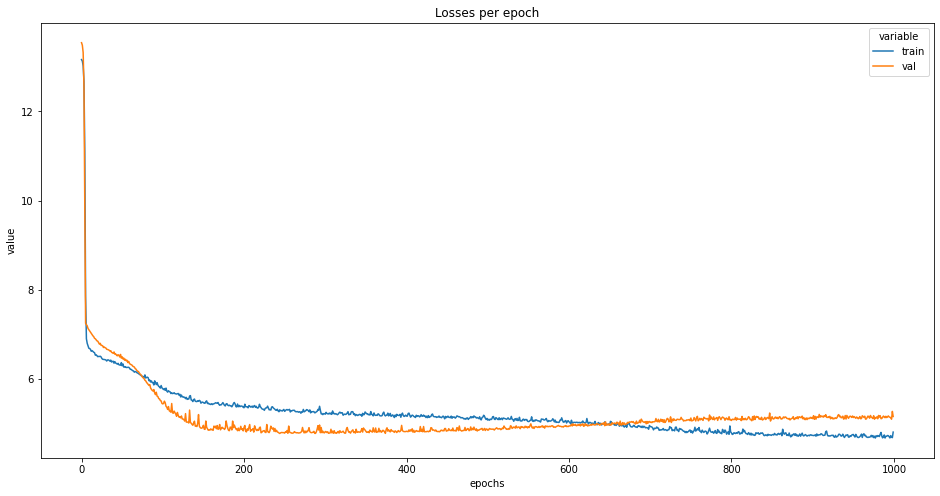

In [ ]:
df_losses_reg = pd.DataFrame.from_dict(loss_dict_reg).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(16,8))
sns.lineplot(data = df_losses_reg, x = "Epochs", y="Loss", hue="variable").set_title('Losses per epoch')

As we can see from the losses, the regressor model performs relatively well and learns fast. We notice some overfitting starting to take place after the 700th epoch (validation loss becomes larger than training loss). Finally, we compare the test MAE of the NN model to that of an XGBoost model. The latter performs slightly better.

In [ ]:
model_pred_list = list()
with torch.no_grad():
    model_regression.eval()
    for test_item, _ in test_loader:
        test_item = test_item.to(device)
        model_pred = model_regression(test_item)
        model_pred_list.append(model_pred.cpu().numpy())
model_pred_list = [pred.squeeze().tolist() for pred in model_pred_list]

In [ ]:
mae_test = mean_absolute_error(y_test, model_pred_list)


In [ ]:

model_XGB = XGBRegressor()
model_XGB.fit(X_train, y_train, verbose=False)
predictions_XGB = model_XGB.predict(X_test)

[12:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print("Mean Squared Error for ANN:",mae_test)
print("Mean Absolute Error for XGB Regresspr: " + str(mean_absolute_error(predictions_XGB, y_test)))

Mean Squared Error for ANN: 5.134185584999571
Mean Absolute Error for XGB Regresspr: 4.973255199874007


To conclude, it can be argued that regression tasks are more promising for the specific (merged) dataset. In a realistic scenario, the business would care more about projecting numbers (possibly sales). Using weather conditions and the time of day for such projections could be profitable on the long run, as waste would be minimized.

Another interesting point is that for tabular data (such as the above) Neural network architectures are not significantly better than simpler algorithms (SVM, XGB). However, due to time constraints, no fine tunig nor in-depth feature engineering was performed.